# Timeseries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dtcj

plt.rcParams['figure.figsize'] = (12,4)
plt.style.use('seaborn')


import statsmodels.api as sm
import itertools

In [2]:
merged = dtcj.load_merged()

When dealing with timeseries information, we recognize that the `y` (sales) value at time `x`is correlated with the previous time value -- that the data are **not independent observations** -- they are part of a continuous phenomena. Does resamples sales really fit this description?

<AxesSubplot:xlabel='datetime'>

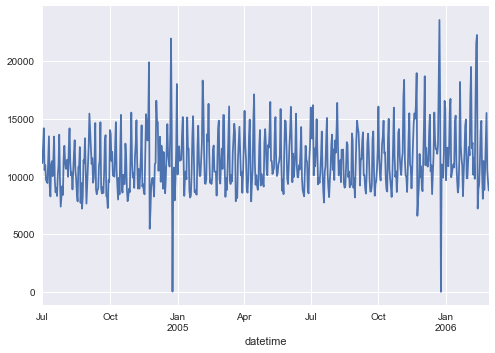

In [4]:
sales_series = merged.resample('D', on='datetime')['SALES_VALUE'].sum()
sales_series.plot()

Great. This data looks much more **stationary -- making it more usable for performing time-series analysis** although we notice that we've lost our second Christmas in the truncation.

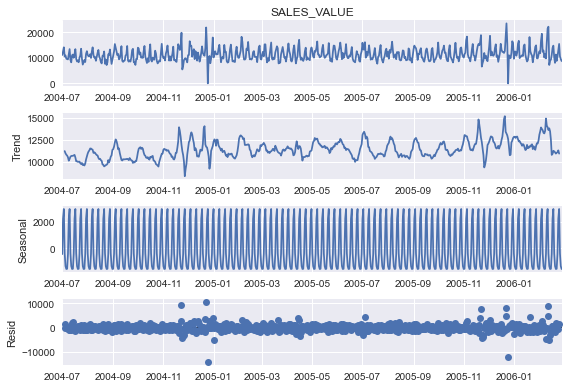

In [5]:
decomposition = sm.tsa.seasonal_decompose(sales_series) #
decomposition.plot()
plt.show()
 

Above, we can see the seasonality of the timeseries; it's trend; and the residuals (or errors). We notice that the christmas/thanksgiving are still anomalous and recognizable, outside of the normal seasonal pattern. 

This makes sense as we used a daily resampling and they are anomalous sales days. These longer-term patterns might be referred to as `cycles`, but I'm not 100% about that.

I'm fascinated with the fast fourier transform, and hope to learn more about it. 
 

In [6]:
len(sales_series) == decomposition.nobs[0]
# the number of observations is given by .nobs

True

In [7]:
# decomposition.resid
# # the variance NOT explained by seasonality or trend os available as .resid

# decomposition.seasonal.plot()

# decomposition.trend.plot()
# # the trend and seasonality are available as well.

# #Collectively, they return the original timeseries;

# (decomposition.trend + decomposition.seasonal + decomposition.resid).plot()
# sales_series.plot(color='orange', alpha=0.4)
 

# ACF and PACF 

The auto-correlation and partial autocorrelation functions (ACF and PACF) are effectively calculated by performing a .shift() for each of a set number of 'lag' periods in the timeseries, and then calculating the correlation between the current value and the shifted value.

For a timeseries where the x-axis is measured in days, this means that each lag period will be equivalent to one day. The shaded area surrounding the x-axis on the plot (the lag periods) reflects the p-value boundary (0.05) of the correlation; therefore, where the lag value is outside of the shaded area, there is a statistically significant effect. 

Time series "stationarity" is a requirement for this form of analysis; and reflects one of the basic tenets of timeseries: that each successive value will have it's state at least partially derived from the previous state. 

**From the basis of lag 0, where correlation is 1, are there any discernible patterns in the correlation plot, and what might that suggest about our underlying data?**

note: PACF reflects the idea that there is a natural disintegration of correlative effects as a timeseries passes forwards. The correlative impact of longer lag times are neutralized somewhat, which in turn allows for better definition of longterm effects when they are significant; there is less 'noise' from repetitive pattern of lower-lag seasonality, without having to filter them out from your analysis directly.
 

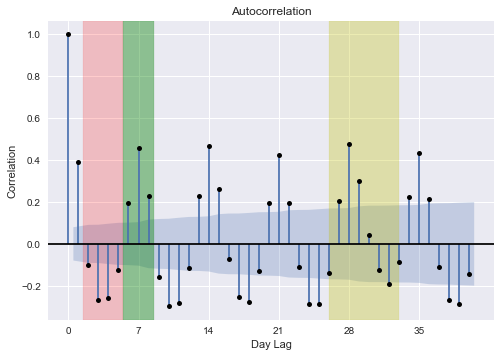

In [8]:
# acf plot
sm.tsa.graphics.plot_acf(sales_series, lags=40, color='black')
plt.axvspan(1.5,5.5, color='red', alpha=0.2)
plt.axvspan(5.5,8.5, color='green', alpha=0.4)
plt.axvspan(26,33, color='y', alpha=0.3)
plt.xticks(range(0, 41, 7))

plt.ylabel('Correlation')
plt.xlabel('Day Lag')
plt.xticks(range(0, 41, 7))
plt.show()
# we can see the correlation between sales on a given day (0), and sales for days with a given 'lag'; 
# there appears to be a repeating 7-day pattern (weekly seasonality)
 

- There is a repeating correlation (7-day seasonality).

- The shaded blue area effectively indicates the p-value; notice that it widens in size as time goes by.  

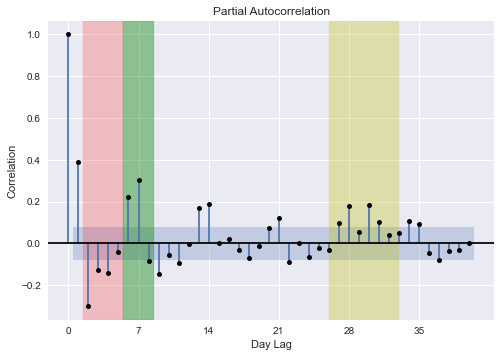

In [9]:
# pacf plot; reducing the signal over time (Recent events are more relevant) 
fig = sm.tsa.graphics.plot_pacf(sales_series, lags=40, color='black')
# in this partial auto-correlation plot we diminish the correlation value, the further we get from day 0. 
plt.axvspan(1.5,5.5, color='red', alpha=0.2)
plt.axvspan(5.5,8.5, color='green', alpha=0.4)
plt.axvspan(26,33, color='y', alpha=0.3)
plt.ylabel('Correlation')
plt.xlabel('Day Lag')
plt.xticks(range(0, 41, 7))
plt.show()
# Note that these are the same lag periods. 

We can see that even with a normalizing term to reduce the correlation over longer periods of time, we still have significant correlation (outside of the shaded blue area). There is an argument to be made that we 

C:\Users\polan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


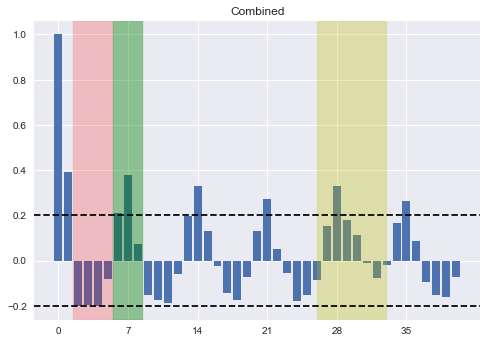

In [10]:
# take the mean of both?
plt.bar(range(0,41), (sm.tsa.pacf(sales_series, nlags=40) + sm.tsa.acf(sales_series, nlags=40))/2) # divide in half
plt.title('Combined')
plt.axhline(0.2, ls='--', color='black')
plt.axhline(-0.2, ls='--', color='black')


plt.axvspan(1.5,5.5, color='red', alpha=0.2)
plt.axvspan(5.5,8.5, color='green', alpha=0.4)
plt.axvspan(26,33, color='y', alpha=0.3)
plt.xticks(range(0, 41, 7))
plt.show()
plt.show()

**There is a 6-7-8 day seasonal effect from the days of the week, and what appears to be a negative 2-3-4 day negative correlation where households generally won't purchase again.**

Interesting to note is the negative 2-day correlation in sales; for any given day when the sales totals were high, the following few days the sales were lower. 

# SARIMAX Model

## Optimizing order and seasonal order


SARIMAX stands for Seasonal Auto Regressive Integrated Moving Average; it seeks to understand the auto-correlation of a timeseries, and extract seasonal and trend patterns in order to examine the residual errors. This allows us to find signals without the interference. 

Below we optimize for p,d,q orders for our SARIMAX model. We can do so using the AIC values for each state-space model.

source: [https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

In [13]:
def test_SARIMAX(sales_series, seasonal_window=7):
    
    
    # set pdq order range
    p = d = q = range(0, 2) 
    
    # make combos
    pdq = list(itertools.product(p, d, q))
    
    ### seasonal PDQM values
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_window) for x in list(itertools.product(p, d, q))]

    # container for lowest AIC score
    lowest = (0, 0, 999999999999)

    # iterate through pdq values up to order 2
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            
            #
            model = sm.tsa.statespace.SARIMAX(sales_series,
                                                order=param,
                                                seasonal_order=param_seasonal)
            results = model.fit()
    #         print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < lowest[2]:
                print(f'SARIMA{param}x{param_seasonal} - AIC:{results.aic} -- lowest:{lowest}')

                lowest = (param, param_seasonal, results.aic)
    #         except:
    #             continue

    return lowest

test_SARIMAX(sales_series)

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:13116.259936544377 -- lowest:(0, 0, 999999999999)
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:12537.462807318232 -- lowest:((0, 0, 0), (0, 0, 0, 7), 13116.259936544377)
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:11203.788581279496 -- lowest:((0, 0, 0), (0, 0, 1, 7), 12537.462807318232)
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:10893.92580646852 -- lowest:((0, 0, 0), (0, 1, 0, 7), 11203.788581279496)
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:10825.66623694721 -- lowest:((0, 0, 0), (0, 1, 1, 7), 10893.92580646852)


C:\Users\polan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 0)x(0, 1, 1, 7) - AIC:10825.483862734916 -- lowest:((0, 0, 1), (0, 1, 1, 7), 10825.66623694721)


C:\Users\polan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\polan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\polan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC:10792.123113250658 -- lowest:((1, 0, 0), (0, 1, 1, 7), 10825.483862734916)


C:\Users\polan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(1, 0, 1, 7) - AIC:1001.8978980118806 -- lowest:((1, 1, 1), (0, 1, 1, 7), 10792.123113250658)


((1, 1, 1), (1, 0, 1, 7), 1001.8978980118806)

## Train Test Split

To train a timeseries-based model, we must reserve the later data for our test set. This is because our data points are not independent -- each value depends on the preceding value. 

One option in this field is to gradually increase the size of our training data, starting from the beginning -- and to test on some number of values which directly follow. Gradually we can take more and more data points in our training, until we reach the extent of our data. This prevents data contamination caused by deriving testing results from all our data at once. 

In [16]:
train = sales_series[:-40]
test = sales_series[-40:] # save the last 40 values for testing.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3025      0.022     13.642      0.000       0.259       0.346
ma.L1         -1.0000      0.022    -45.795      0.000      -1.043      -0.957
ar.S.L7        0.0359      0.041      0.874      0.382      -0.045       0.116
ma.S.L7       -0.9452      0.025    -37.952      0.000      -0.994      -0.896
sigma2      3.292e+06   6.63e-09   4.96e+14      0.000    3.29e+06    3.29e+06


C:\Users\polan\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


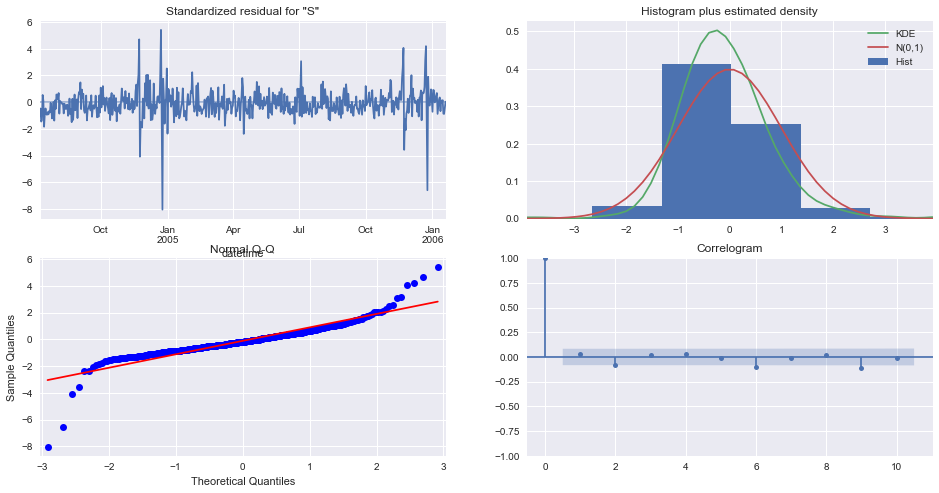

In [17]:
# instantiate
model = sm.tsa.statespace.SARIMAX(train,
                          order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),) # use the optimized parameters

# fit
results = model.fit()
# score
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

We've trained this state-space model on the beginning of our timeseries, hoping to predict the values near the end. By optimizing the seasonality/lag parameters (above), we can extract the seasonal effects from our predictions. We can see that by using this model, we've reduced the seasonal pattern to within a reasonable probability distribution.

## Making Predictions

Below we display our SARIMAX model predictions.

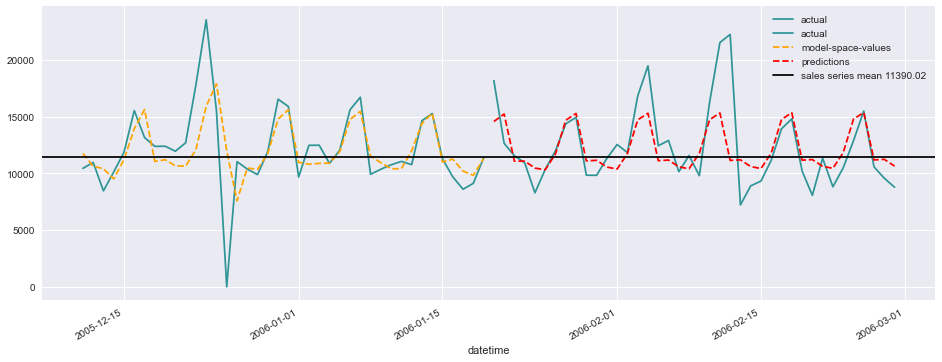

In [18]:
plt.figure(figsize=(16,6))

# plot actual values
plt.plot(test, label='actual', color='teal', alpha=0.8)
plt.plot(train[-40:], label='actual', color='teal', alpha=0.8)
# the next 40 predicted values

# the generated model (space predictions)
results.predict(-40).plot(ls='--', label='model-space-values', color='orange')
plt.plot(results.forecast(40), ls='--', label='predictions', color='red')


# adding mean line
plt.axhline(sales_series.mean(), label=f'sales series mean {round(sales_series.mean(),2)}', color='black')
plt.legend()

In the above plot, we can see Christmas 2005, as well as the storm of February 2006 reflected in our data. Looks pretty good! What's our level of error?

In [19]:
results.mae 

1319.9712897074214

In [20]:
(results.mae/11390) *100 ## 11390 is the mean of the series

11.588861191461119

In [21]:
np.std(sales_series)

2596.0308515206857

In [22]:
# Conclusions

This model has a mean average error of more than 10% of the total sales value per day, which poses significant monetary risk. 

However, this \$1300 is only about half of one standard deviation from the sales_series mean (of the data we have...), which is pretty impressive, all things considered. 

# Conclusions and Moving Forward

We could perform this sort of timeseries analysis for any subsection of our customers, to examine that subsection's purchase patterns. For now, suffice to say we have a 7 day seasonal pattern which manifests for 2-week, 3-week, and 4-week sections; blending into a monthly pattern.